# CIDS-Sim with Non-IID data

Federated Learning enables collaboration among multiple clients to learn from decentralized data. In the context of Collaborative Intrusion Detection Systems (CIDS), each client serves as a detector unit distributed across different networks, while the central server, responsible for aggregating the models, functions as the correlation unit. This simulator operates in a non-IID (Non-Independent and Identically Distributed) data environment, where data is distributed across clients in a heterogeneous manner. For this simulation, the CoAt_NF-UQ-NIDS-V2.parquet dataset is used, with the data split non-IID across clients. The Federated Averaging (FedAvg) algorithm is employed to aggregate the models from multiple clients.

## CIDS Architecture

<p align="center">
    <img width="699" alt="image" src="https://github.com/aulwardana/CIDS-Sim/blob/main/images/arch_CIDS-Sim_Non-IID.jpg?raw=true">
</p>


## Dataset

This simulator will use a Coordinated Attack dataset from [here](https://data.mendeley.com/datasets/28tmfg3rzb/2).

## Other Information

The simulator will run binary classification, so the traffic will labeled as normal (0) or anomaly (1)

---

First, import libraries

---

In [1]:
import numpy as np
import pandas as pd
import time
import psutil
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Recall, Precision

from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

2025-01-28 09:30:02.831273: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 09:30:02.835052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 09:30:02.845187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 09:30:02.861155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 09:30:02.866030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 09:30:02.878937: I tensorflow/core/platform/cpu_feature_gu

---

Load Coordinated Attack dataset. We are using ".parquet" file for faster reading data.

Use `CoAt_NF-UQ-NIDS-V2.parquet` for a dataset with the NF feature for the Non-IID scenario.

---

In [2]:
# Define the path to the dataset file
file_path = os.path.join('..', '..', 'dataset', 'CoAt_NF-UQ-NIDS-V2.parquet')

# Use this to read dataset using parquet file (default)
df = pd.read_parquet(file_path, engine='pyarrow')

---

View the dataset information

---

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 43 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

Choose a binary label, so we drop the multi-class label

---

In [4]:
df = df.drop(columns=['Label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43636597 entries, 2 to 62672010
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   L4_SRC_PORT                  int16  
 1   L4_DST_PORT                  int16  
 2   PROTOCOL                     int16  
 3   L7_PROTO                     float32
 4   IN_BYTES                     int32  
 5   IN_PKTS                      int32  
 6   OUT_BYTES                    int32  
 7   OUT_PKTS                     int32  
 8   TCP_FLAGS                    int16  
 9   CLIENT_TCP_FLAGS             int16  
 10  SERVER_TCP_FLAGS             int16  
 11  FLOW_DURATION_MILLISECONDS   int32  
 12  DURATION_IN                  int32  
 13  DURATION_OUT                 int32  
 14  MIN_TTL                      int16  
 15  MAX_TTL                      int16  
 16  LONGEST_FLOW_PKT             int32  
 17  SHORTEST_FLOW_PKT            int16  
 18  MIN_IP_PKT_LEN               int16  
 19  MAX

---

View normal (0) and anomaly (1) traffic distribution

---

In [5]:
df['Attack'].value_counts()

Attack
1    22892774
0    20743823
Name: count, dtype: int64

---

X and y are used to represent the input features and the corresponding target labels, respectively.

---

In [6]:
X_df = df.drop(columns=['Attack'])
y_df = df['Attack']

---

Scaling data to ensures that features have values in the same range

---

In [7]:
# Use this scaler for NF dataset
scaler = QuantileTransformer(output_distribution='normal')

In [8]:
X_df_scl = scaler.fit_transform(X_df)

---

This Python function, `load_data(client_id)`, is designed to load a portion of data for a specific client in a Federated Learning setting where non-IID data is distributed among different clients. That process is designed to divide a large dataset into smaller portions for different clients.

Please change `fraction` variable if you want to change the data portion that will distribute to each client.

---

In [9]:
def load_data(client_id):
    
    # Create non-IID splits based on client_id
    np.random.seed(client_id)
    indices = np.arange(len(X_df_scl))
    np.random.shuffle(indices)

    # Choose a fraction of the data for this client
    fraction = 0.02
    client_data_size = int(fraction * len(X_df_scl))
    client_indices = indices[:client_data_size]

    X_client = X_df_scl[client_indices]
    y_client = y_df.iloc[client_indices]

    return X_client, y_client

---

The `create_model()` function defines a simple deep neural network model using Keras.
You can change the **number of neurons** in each **Dense layer**.
You can also experiment by changing the **Activation function, Loss function, and optimizer** from the deep learning model.

---

In [10]:
# Define a simple neural network model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Dense(20, activation='relu', input_shape=(input_shape,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(3, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', Recall(), Precision()])
    return model

---

Calculate model size to measure the overhead in communication

---

In [11]:
def calculate_model_size(model):
    """Calculate the size of a model (in bytes) by summing the number of parameters."""
    total_params = np.sum([np.prod(weights.shape) for weights in model.get_weights()])
    size_in_bytes = total_params * 4  # Assuming 32-bit float (4 bytes per parameter)
    return size_in_bytes

---

Calculate F1-Score

---

In [12]:
def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)
    return f1_score

---

The `cids_federated_training()` function implements the **training process for a Collaborative Intrusion Detection System (CIDS) using Federated Learning**. The goal is to train a global model based on the local training of models across multiple distributed nodes, without sharing raw data. 

This function performs federated learning for intrusion detection across `num_nodes` (clients or devices) over `num_rounds` (iterations of federated learning). You can experiment by changing `num_nodes` and `num_rounds` from this function.

---

In [13]:
# CIDS with federated learning training process

# change num_nodes and num_rounds for your simulation scenario

def cids_federated_training(num_nodes=5, num_rounds=5): 
    input_shape_glob = X_df_scl.shape[1]
    global_model = create_model(input_shape=input_shape_glob)
    global_weights = global_model.get_weights()

    global_pred_times = []

    # Calculate model size (bytes per round of communication)
    model_size = calculate_model_size(global_model)
    print(f"Model size: {model_size / 1e6:.2f} MB")

    communication_overhead = 0

    #Global model performance evaluation
    global_accuracies = []
    global_precisions = []
    global_recalls = []
    global_f1s = []

    # Variable for global training and prediction time
    total_training_times = []
    total_prediction_times = []

    # Variable for global training CPU and Memory usage
    cpu_usages = []
    memory_usages = []

    # Variable for global variance in performance across nodes
    accuracy_variances = []
    precision_variances = []
    recall_variances = []
    f1_variances = []

    # Variable for global standard deviation of performance
    accuracy_stds = []
    precision_stds = []
    recall_stds = []
    f1_stds = []

    # Initial evaluation
    X_test, Y_test = load_data(num_nodes+1)

    # Training rounds
    for round in range(num_rounds):
        local_weights = []
        local_training_times = []
        local_prediction_times = []

        #Local model performance evaluation
        local_accuracies = []
        local_precisions = []
        local_recalls = []
        local_f1s = []

        # Local CPU and Memory usage
        round_cpu_usage = []
        round_memory_usage = []

        print(f"\n------------------------------------------------------------\n")
        print(f"Training Round {round + 1}\n")

        for node in range(num_nodes):
            X, Y = load_data(node)
                    
            X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
            
            input_shape = X_train.shape[1]

            model = create_model(input_shape=input_shape)
            model.set_weights(global_weights)

            # Measure CPU and memory utilization during training
            cpu_before = psutil.cpu_percent(interval=None)
            memory_before = psutil.virtual_memory().percent

            # Measure local training time
            start_train_time = time.time()
            #local training time
            model.fit(X_train, Y_train, epochs=10, batch_size=1000, verbose=0)
            end_train_time = time.time()

            cpu_after = psutil.cpu_percent(interval=None)
            memory_after = psutil.virtual_memory().percent

            local_training_time = end_train_time - start_train_time
            local_training_times.append(local_training_time)

            cpu_usage = cpu_after - cpu_before
            memory_usage = memory_after - memory_before

            print(f"Node {node + 1}: Training Time {local_training_time:.4f} seconds")
            print(f"Node {node + 1}: CPU Usage {cpu_usage:.2f}% - Memory Usage {memory_usage:.2f}%")

            # Measure local resource consumption
            round_cpu_usage.append(cpu_usage)
            round_memory_usage.append(memory_usage)

            # Measure local prediction time
            start_pred_time = time.time()
            # Validation
            loss, accuracy, precision, recall = model.evaluate(X_val, Y_val, verbose=0)
            end_pred_time = time.time()

            local_prediction_time = end_pred_time - start_pred_time
            local_prediction_times.append(local_prediction_time)

            print(f"Node {node + 1}: Prediction Time {local_prediction_time:.4f} seconds")
            
            f1_score = calculate_f1_score(precision, recall)
            print(f"Node {node + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

            #Append local performance data
            local_accuracies.append(accuracy)
            local_precisions.append(precision)
            local_recalls.append(recall)
            local_f1s.append(f1_score)
            
            local_weights.append(model.get_weights())

            # Communication: Server receiving weights from each node
            communication_overhead += model_size

        # Measure server aggregation time
        start_aggregation_time = time.time()
        # Aggregate weights
        new_weights = [np.mean([weight[layer] for weight in local_weights], axis=0) for layer in range(len(global_weights))]
        end_aggregation_time = time.time()
        
        aggregation_time = end_aggregation_time - start_aggregation_time
        print(f"Aggregation Time round {round + 1}: {aggregation_time:.4f} seconds")
        
        global_weights = new_weights
        global_model.set_weights(global_weights)

        # Communication: Server sending updated weights to all nodes
        communication_overhead += num_nodes * model_size

        print(f"Total communication overhead after round {round + 1}: {communication_overhead / 1e6:.2f} MB")

        # Evaluate and measure the time
        start_glob_pred_time = time.time()
        loss, accuracy, precision, recall = model.evaluate(X_test, Y_test, verbose=0)
        end_glob_pred_time = time.time()

        global_pred_time = end_glob_pred_time - start_glob_pred_time
        global_pred_times.append(global_pred_time)

        print(f"\nGlobal Prediction Time Round {round + 1}: {global_pred_time:.4f}")

        # Evaluate global model accuracy
        f1_score = calculate_f1_score(precision, recall)
        global_accuracies.append(accuracy)
        global_precisions.append(precision)
        global_recalls.append(recall)
        global_f1s.append(f1_score)
        
        print(f"\nRound {round + 1}: Accuracy {accuracy:.4f} - Precision {precision:.4f} - Recall {recall:.4f} - F1-Score {f1_score:.4f}\n")

        # Cross-node Generalization Calculation
        accuracy_variance = np.var(local_accuracies)
        accuracy_variances.append(accuracy_variance)
        precision_variance = np.var(local_precisions)
        precision_variances.append(precision_variance)
        recall_variance = np.var(local_recalls)
        recall_variances.append(recall_variance)
        f1_variance = np.var(local_f1s)
        f1_variances.append(f1_variance)

        accuracy_std = np.std(local_accuracies)
        accuracy_stds.append(accuracy_std)
        precision_std = np.std(local_precisions)
        precision_stds.append(precision_std)
        recall_std = np.std(local_recalls)
        recall_stds.append(recall_std)
        f1_std = np.std(local_f1s)
        f1_stds.append(f1_std)

        print(f"Cross-node Generalization after Round {round + 1}:")
        print(f"Accuracy Variance: {accuracy_variance:.4f}, Accuracy Std: {accuracy_std:.4f}")
        print(f"Precision Variance: {precision_variance:.4f}, Precision Std: {precision_std:.4f}")
        print(f"Recall Variance: {recall_variance:.4f}, Recall Std: {recall_std:.4f}")
        print(f"F1-Score Variance: {f1_variance:.4f}, F1-Score Std: {f1_std:.4f}\n")

        # Calculate total training time for the round
        total_training_time = sum(local_training_times) + aggregation_time
        total_training_times.append(total_training_time)

        print(f"\nTotal Training Time Round {round + 1}: {total_training_time:.4f}")

        # Calculate total prediction time for the round
        total_prediction_time = sum(local_prediction_times)
        total_prediction_times.append(total_prediction_time)

        print(f"\nTotal Prediction Time Round {round + 1}: {total_prediction_time:.4f}")

        # Append round-level resource utilization
        cpu_usages.append(np.mean(round_cpu_usage))
        memory_usages.append(np.mean(round_memory_usage))

    return global_model, global_accuracies, global_precisions, global_recalls, global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds

---

Run the simulation, then get the global model and perfromance metric in each round.

---

In [14]:
# Run CIDS simulator with Non-IID data from single dataset
print("Simulation for CIDS with Non-IID Data\n")
fl_model, fl_global_accuracies, fl_global_precisions, fl_global_recalls, fl_global_f1s, communication_overhead, total_training_times, total_prediction_times, global_pred_times, cpu_usages, memory_usages, accuracy_variances, precision_variances, recall_variances, f1_variances, accuracy_stds, precision_stds, recall_stds, f1_stds = cids_federated_training()

Simulation for CIDS with Non-IID Data

Model size: 0.00 MB


/home/awardana/miniconda3/envs/cids_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



------------------------------------------------------------

Training Round 1

Node 1: Training Time 7.9240 seconds
Node 1: CPU Usage 2.80% - Memory Usage 0.50%
Node 1: Prediction Time 3.4951 seconds
Node 1: Accuracy 0.9265 - Precision 0.9263 - Recall 0.9330 - F1-Score 0.9297

Node 2: Training Time 7.7868 seconds
Node 2: CPU Usage 1.90% - Memory Usage 0.10%
Node 2: Prediction Time 3.4414 seconds
Node 2: Accuracy 0.9237 - Precision 0.9155 - Recall 0.9379 - F1-Score 0.9266

Node 3: Training Time 7.6856 seconds
Node 3: CPU Usage 1.80% - Memory Usage 0.00%
Node 3: Prediction Time 3.4659 seconds
Node 3: Accuracy 0.9276 - Precision 0.9281 - Recall 0.9332 - F1-Score 0.9307

Node 4: Training Time 7.8296 seconds
Node 4: CPU Usage 2.00% - Memory Usage 0.10%
Node 4: Prediction Time 3.5198 seconds
Node 4: Accuracy 0.9244 - Precision 0.9190 - Recall 0.9359 - F1-Score 0.9273

Node 5: Training Time 7.6985 seconds
Node 5: CPU Usage 1.90% - Memory Usage 0.00%
Node 5: Prediction Time 3.4770 seconds
No

In [15]:
print(f"\nFinal Communication Overhead: {communication_overhead / 1e6:.2f} MB")


Final Communication Overhead: 0.23 MB


---

Plot the performance metric in each round using graph

---

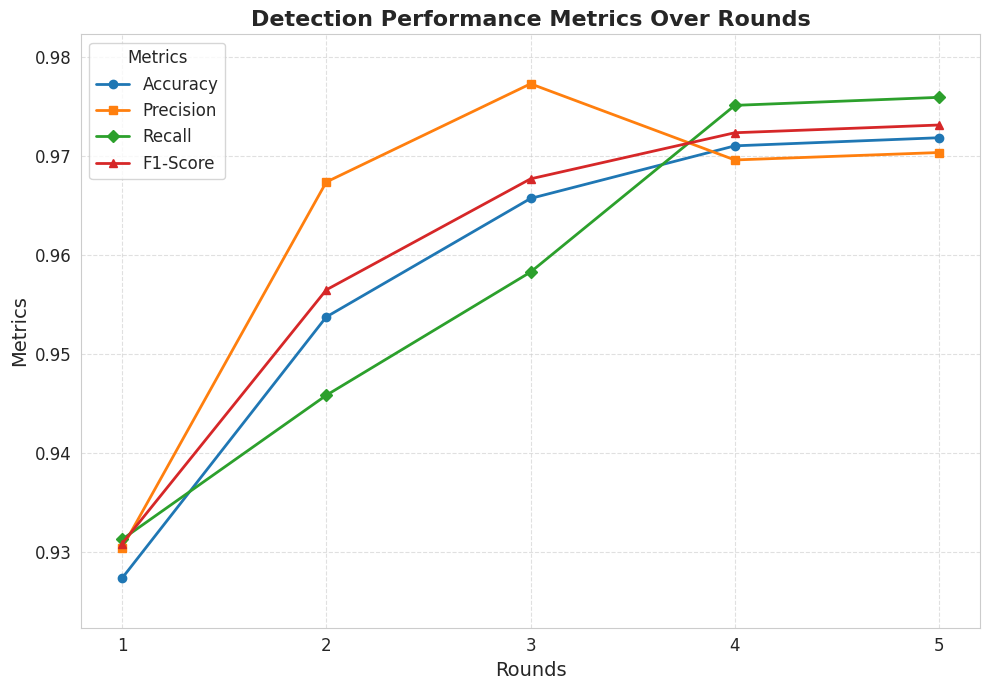

In [16]:
# Set the style of the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values1 = fl_global_accuracies + fl_global_precisions + fl_global_recalls + fl_global_f1s
y_min1 = min(all_values1) - 0.005  # Add margin below
y_max1 = max(all_values1) + 0.005  # Add margin above

rounds1 = np.arange(1, len(fl_global_accuracies) + 1)

plt.plot(rounds1, fl_global_accuracies, marker='o', label='Accuracy', linewidth=2, color='#1f77b4')
plt.plot(rounds1, fl_global_precisions, marker='s', label='Precision', linewidth=2, color='#ff7f0e')
plt.plot(rounds1, fl_global_recalls, marker='D', label='Recall', linewidth=2, color='#2ca02c')
plt.plot(rounds1, fl_global_f1s, marker='^', label='F1-Score', linewidth=2, color='#d62728')

# Add titles and labels
plt.title('Detection Performance Metrics Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds1, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min1, y_max1)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

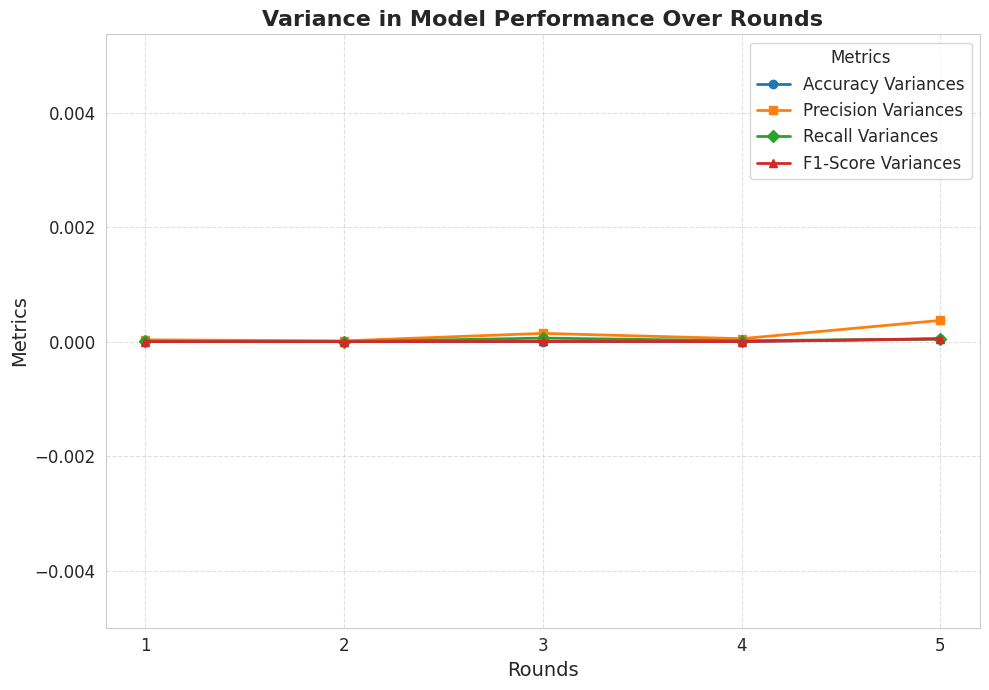

In [17]:
# Plotting model robustness and generalization results
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values2 = accuracy_variances + precision_variances + recall_variances + f1_variances
y_min2 = min(all_values2) - 0.005  # Add margin below
y_max2 = max(all_values2) + 0.005  # Add margin above

rounds2 = np.arange(1, len(accuracy_variances) + 1)

plt.plot(rounds2, accuracy_variances, marker='o', label='Accuracy Variances', linewidth=2, color='#1f77b4')
plt.plot(rounds2, precision_variances, marker='s', label='Precision Variances', linewidth=2, color='#ff7f0e')
plt.plot(rounds2, recall_variances, marker='D', label='Recall Variances', linewidth=2, color='#2ca02c')
plt.plot(rounds2, f1_variances, marker='^', label='F1-Score Variances', linewidth=2, color='#d62728')

# Add titles and labels
plt.title('Variance in Model Performance Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds2, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min2, y_max2)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

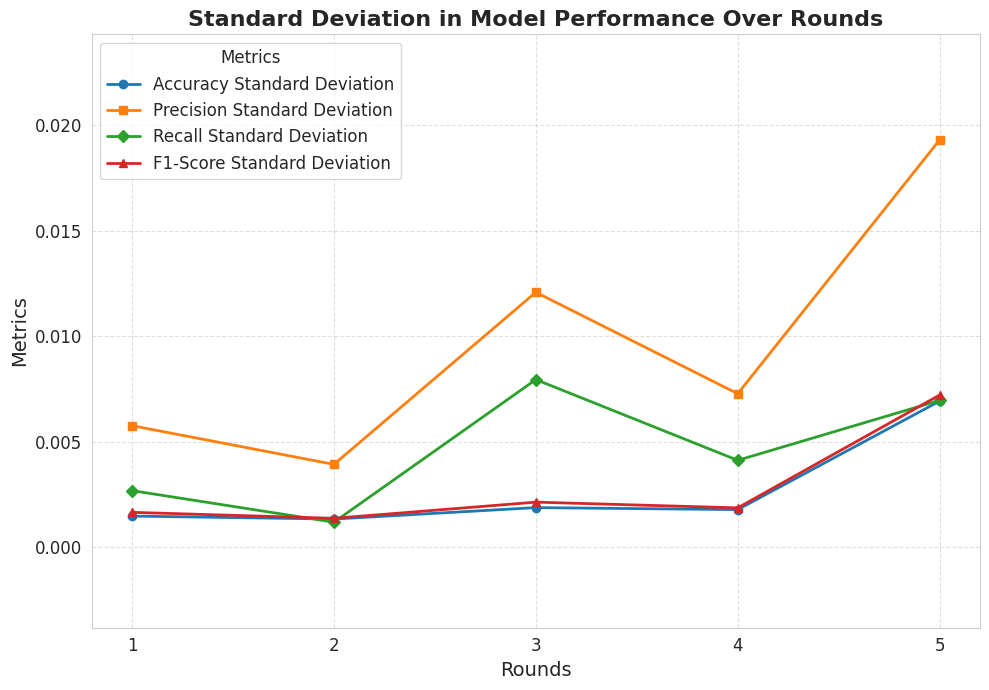

In [18]:
# Plotting model robustness and generalization results
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values3 = accuracy_stds + precision_stds + recall_stds + f1_stds
y_min3 = min(all_values3) - 0.005  # Add margin below
y_max3 = max(all_values3) + 0.005  # Add margin above

rounds3 = np.arange(1, len(accuracy_stds) + 1)

plt.plot(rounds3, accuracy_stds, marker='o', label='Accuracy Standard Deviation', linewidth=2, color='#1f77b4')
plt.plot(rounds3, precision_stds, marker='s', label='Precision Standard Deviation', linewidth=2, color='#ff7f0e')
plt.plot(rounds3, recall_stds, marker='D', label='Recall Standard Deviation', linewidth=2, color='#2ca02c')
plt.plot(rounds3, f1_stds, marker='^', label='F1-Score Standard Deviation', linewidth=2, color='#d62728')

# Add titles and labels
plt.title('Standard Deviation in Model Performance Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds3, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min3, y_max3)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

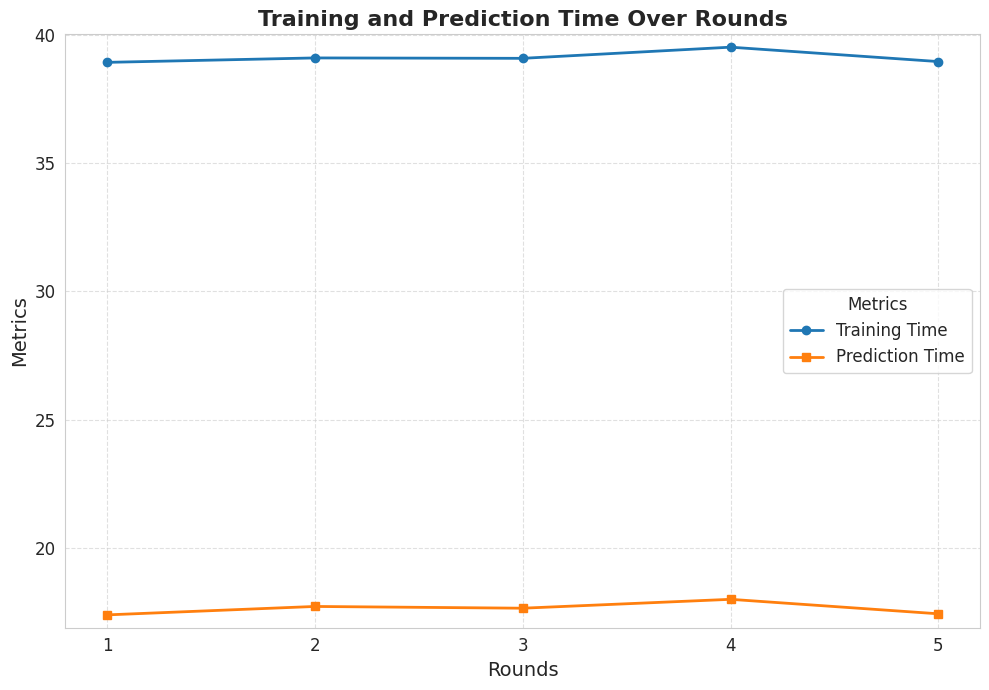

In [19]:
# Plotting training and prediction time
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values4 = total_training_times + total_prediction_times
y_min4 = min(all_values4) - 0.5  # Add margin below
y_max4 = max(all_values4) + 0.5  # Add margin above

rounds4 = np.arange(1, len(total_training_times) + 1)

plt.plot(rounds4, total_training_times, marker='o', label='Training Time', linewidth=2, color='#1f77b4')
plt.plot(rounds4, total_prediction_times, marker='s', label='Prediction Time', linewidth=2, color='#ff7f0e')

# Add titles and labels
plt.title('Training and Prediction Time Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds4, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min4, y_max4)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

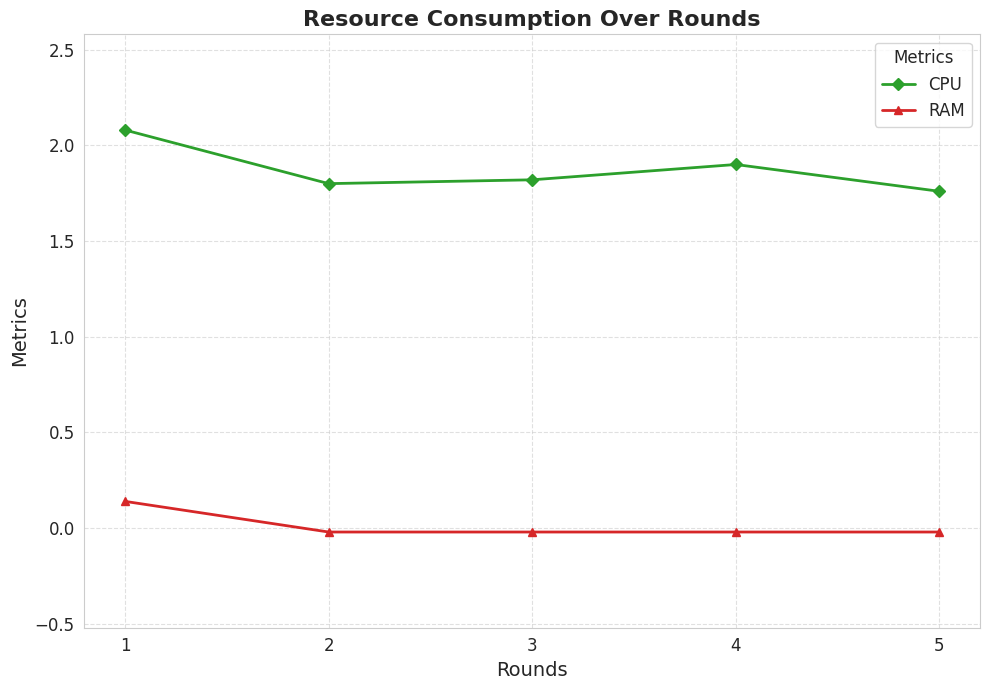

In [20]:
# Plotting resource consumption
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values5 = cpu_usages + memory_usages
y_min5 = min(all_values5) - 0.5  # Add margin below
y_max5 = max(all_values5) + 0.5  # Add margin above

rounds5 = np.arange(1, len(cpu_usages) + 1)

plt.plot(rounds5, cpu_usages, marker='D', label='CPU', linewidth=2, color='#2ca02c')
plt.plot(rounds5, memory_usages, marker='^', label='RAM', linewidth=2, color='#d62728')

# Add titles and labels
plt.title('Resource Consumption Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds5, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min5, y_max5)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

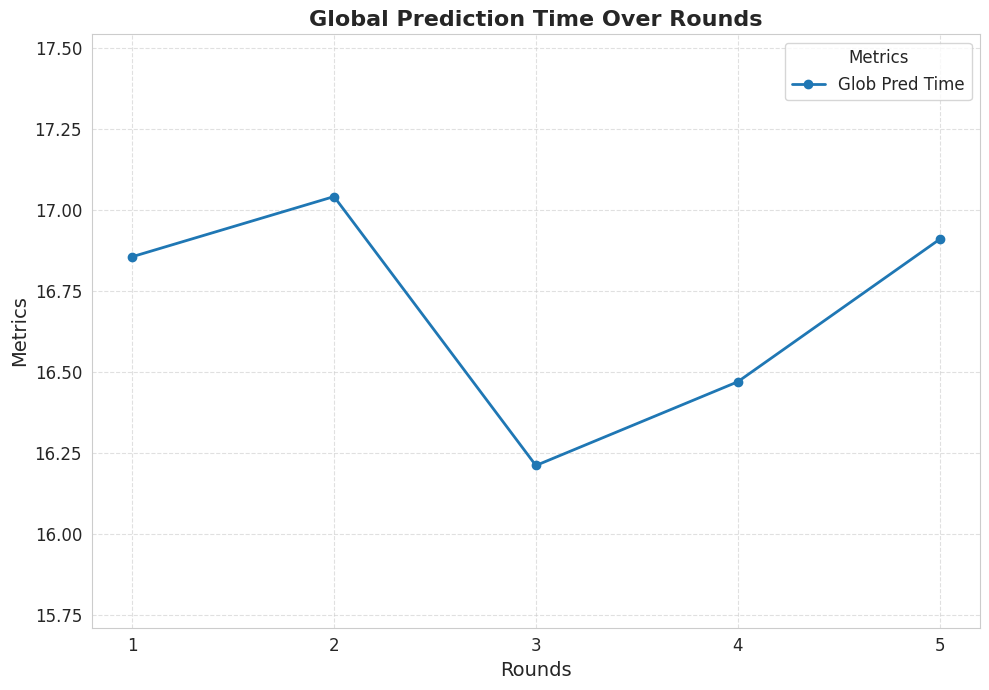

In [21]:
# Plotting global prediction time
plt.figure(figsize=(10, 7))

# Calculate dynamic y-axis range
all_values6 = global_pred_times
y_min6 = min(all_values6) - 0.5  # Add margin below
y_max6 = max(all_values6) + 0.5  # Add margin above

rounds6 = np.arange(1, len(global_pred_times) + 1)

plt.plot(rounds6, global_pred_times, marker='o', label='Glob Pred Time', linewidth=2, color='#1f77b4')

# Add titles and labels
plt.title('Global Prediction Time Over Rounds', fontsize=16, weight='bold')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Metrics', fontsize=14)

# Add a legend
plt.legend(title='Metrics', fontsize=12, title_fontsize=12)

# Improve layout
plt.xticks(rounds6, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(y_min6, y_max6)  # Set y-axis limits for better clarity

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()

---

Save the performance metric in each round in CSV file

---

In [22]:
# Number of rounds
rounds = list(range(1, len(fl_global_accuracies) + 1))

# Save global performance metrics with rounds
global_metrics_df = pd.DataFrame({
    "Round": rounds,
    "Global Accuracy": fl_global_accuracies,
    "Global Precision": fl_global_precisions,
    "Global Recall": fl_global_recalls,
    "Global F1-Score": fl_global_f1s,
    "Global Prediction Time": global_pred_times,
    "Total Training Times": total_training_times,
    "Total Prediction Times": total_prediction_times,
    "CPU Usage": cpu_usages,
    "Memory Usage": memory_usages,
    "Accuracy Variance": accuracy_variances,
    "Precision Variance": precision_variances,
    "Recall Variance": recall_variances,
    "F1 Variance": f1_variances,
    "Accuracy Std": accuracy_stds,
    "Precision Std": precision_stds,
    "Recall Std": recall_stds,
    "F1 Std": f1_stds
})

# Export global metrics to a CSV
global_metrics_df.to_csv("performance_metrics_CIDS_Non-IID.csv", index=False)

print("All metrics exported to CSV files successfully.")

All metrics exported to CSV files successfully.
